In [32]:
import fastf1 as ff1
import pandas as pd
import logging

# Disable info logs
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Enable the cache
ff1.Cache.enable_cache('cache')

# Get race data
race = ff1.get_session(2021, 'Abu Dhabi', 'R')
laps = race.load_laps(with_telemetry=True)

# Load leaders
laps_ham = laps.pick_driver('HAM')
laps_ver = laps.pick_driver('VER')

# Remove warm-up lap
laps_ham['RaceLapNumber'] = laps_ham['LapNumber'] - 1
laps_ver['RaceLapNumber'] = laps_ver['LapNumber'] - 1

In [33]:
import numpy as np

full_distance_ver_ham = pd.DataFrame()
summarized_distance_ver_ham = pd.DataFrame()

for lap in laps_ver.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    
    # Only run this loop when driver ahead is HAM, otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "44"]
    
    if len(telemetry) != 0:
        # Full distance
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]
        lap_telemetry.loc[:, 'Lap'] = lap[0] + 1

        full_distance_ver_ham = full_distance_ver_ham.append(lap_telemetry)

        # Average / median distance
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])

        summarized_distance_ver_ham = summarized_distance_ver_ham.append({
            'Lap': lap[0] + 1,
            'Mean': distance_mean,
            'Median': distance_median
        }, ignore_index = True)

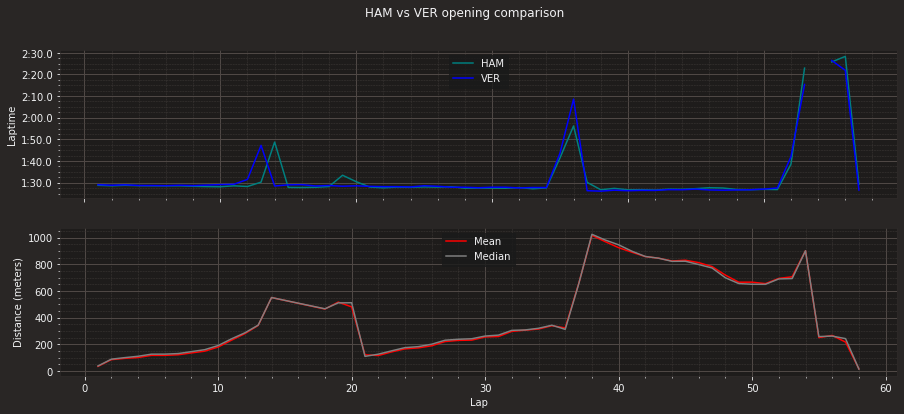

In [41]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

plotting.setup_mpl()
pd.options.mode.chained_assignment = None

plt.rcParams['figure.figsize'] = [15, 6]

fig, ax = plt.subplots(2)
fig.suptitle("HAM vs VER opening comparison")

ax[0].plot(laps_ham['RaceLapNumber'], laps_ham['LapTime'], label='HAM', color="teal")
ax[0].plot(laps_ver['RaceLapNumber'], laps_ver['LapTime'], label='VER', color="blue")
ax[0].set(ylabel='Laptime', xlabel='Lap')
ax[0].legend(loc="upper center")

ax[1].plot(summarized_distance_ver_ham['Lap'], summarized_distance_ver_ham['Mean'], label='Mean', color='red')
ax[1].plot(summarized_distance_ver_ham['Lap'], summarized_distance_ver_ham['Median'], label='Median', color='grey')
ax[1].set(ylabel='Distance (meters)', xlabel='Lap')
ax[1].legend(loc="upper center")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

plt.show()